In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname('.'), 'src'))

from visualization.visualization import plot_learning_curves
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
def order_points(pts):
    """Orders the four corner points of a rectangle."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def extract_surface_data(image_path: str) -> np.ndarray:
    """Extracts a 2D data matrix from an image of a 3D surface plot."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 50, 50])
    upper_bound = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("Could not find any data contours in the image.")
    main_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(main_contour)
    box = cv2.boxPoints(rect)
    src_pts = order_points(box)
    (tl, tr, br, bl) = src_pts
    width_a = np.linalg.norm(br - bl)
    width_b = np.linalg.norm(tr - tl)
    max_width = max(int(width_a), int(width_b))
    height_a = np.linalg.norm(tr - br)
    height_b = np.linalg.norm(tl - bl)
    max_height = max(int(height_a), int(height_b))
    dst_pts = np.array([[0, 0], [max_width - 1, 0], [max_width - 1, max_height - 1], [0, max_height - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_hsv = cv2.warpPerspective(hsv, M, (max_width, max_height))
    warped_mask = cv2.warpPerspective(mask, M, (max_width, max_height))
    hue_channel = warped_hsv[:, :, 0]
    valid_hues = hue_channel[warped_mask > 0]
    if len(valid_hues) == 0:
        raise ValueError("Warped image contains no valid data pixels.")
    h_min, h_max = np.min(valid_hues), np.max(valid_hues)
    result_matrix = np.full(hue_channel.shape, np.nan, dtype=np.float32)
    if h_max - h_min > 0:
        normalized_values = (h_max - hue_channel[warped_mask > 0]) / (h_max - h_min)
    else:
        normalized_values = 0.5
    result_matrix[warped_mask > 0] = normalized_values
    return result_matrix



In [3]:
df_features = pd.read_csv('./data/processed/surface_features_processed.csv')

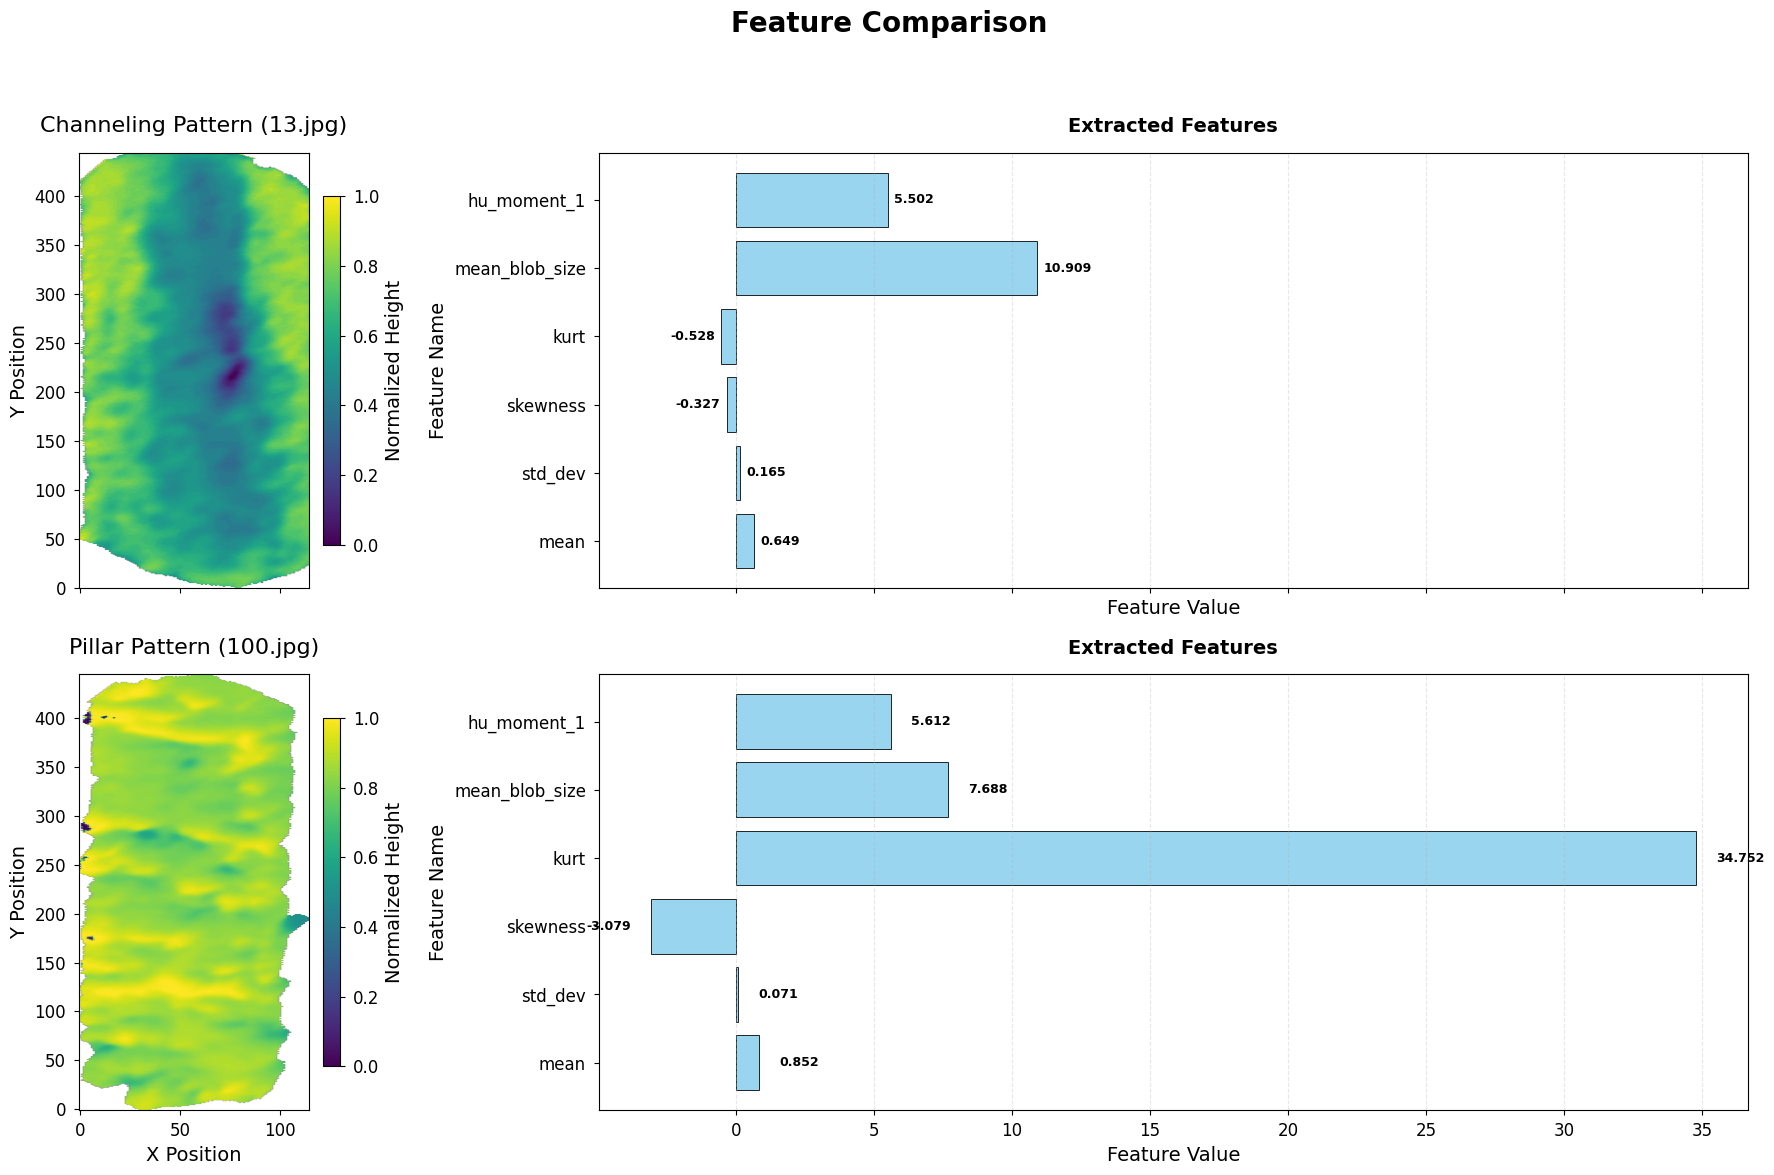

In [6]:

def plot_features(ax, features, color, title):
    """
    Helper function to create a styled horizontal bar plot for features.
    Handles smart label placement for positive and negative values.
    """
    # Plot the bars
    bars = ax.barh(features.index, features.values, color=color, alpha=0.85, edgecolor='black', linewidth=0.7)
    
    # Set titles and labels
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Feature Name')
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    
    # Invert y-axis to match the order in the DataFrame
    ax.invert_yaxis()
    
    # Add smart value labels to bars
    padding = ax.get_xlim()[1] * 0.02  # 2% of the x-axis range for padding
    for bar in bars:
        width = bar.get_width()
        if width >= 0:
            # Positive bar: label to the right
            ax.text(width + padding, bar.get_y() + bar.get_height() / 2,
                    f'{width:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
        else:
            # Negative bar: label to the left
            ax.text(width - padding, bar.get_y() + bar.get_height() / 2,
                    f'{width:.3f}', ha='right', va='center', fontsize=9, fontweight='bold')


# --- Main Plotting Script ---

# Set a clean, modern style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'sans-serif' # Sans-serif is often cleaner for plots
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Get data for the selected images
image1_path = './data/augmented_dataset/Channeling/13.jpg'
image2_path = './data/augmented_dataset/Pillar/85.jpg'

matrix1 = extract_surface_data(image1_path)
matrix2 = extract_surface_data(image2_path)

features1 = df_features[df_features['filename'] == '13.jpg'].drop(['filename', 'label'], axis=1).iloc[0]
features2 = df_features[df_features['filename'] == '85.jpg'].drop(['filename', 'label'], axis=1).iloc[0]

# Create figure with subplots - use sharex=True for direct comparison!
fig, axes = plt.subplots(2, 2, figsize=(18, 12), 
                         gridspec_kw={'width_ratios': [1, 4]},
                         sharex='col', # Share x-axis for columns (affects feature plots)
                         sharey='col'  # Share y-axis for columns (good practice)
                        )

# Overall title for the entire figure
fig.suptitle('Feature Comparison', 
             fontsize=20, fontweight='bold')

# --- Row 1: Channeling Pattern ---
# Topography Plot
im1 = axes[0, 0].imshow(matrix1, cmap='viridis', origin='lower', aspect='auto')
axes[0, 0].set_title('Channeling Pattern (13.jpg)', pad=15)
axes[0, 0].set_ylabel('Y Position')
fig.colorbar(im1, ax=axes[0, 0], shrink=0.8, label='Normalized Height')

# Feature Plot
plot_features(axes[0, 1], features1, 'skyblue', 'Extracted Features')

# --- Row 2: Pillar Pattern ---
# Topography Plot
im2 = axes[1, 0].imshow(matrix2, cmap='viridis', origin='lower', aspect='auto')
axes[1, 0].set_title('Pillar Pattern (100.jpg)', pad=15)
axes[1, 0].set_xlabel('X Position')
axes[1, 0].set_ylabel('Y Position')
fig.colorbar(im2, ax=axes[1, 0], shrink=0.8, label='Normalized Height')

# Feature Plot
plot_features(axes[1, 1], features2, 'skyblue', 'Extracted Features')

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95]) # rect leaves space at the top for the suptitle
plt.show()

C:\Users\0xRust\AppData\Local\Temp\ipykernel_6852\709744352.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)


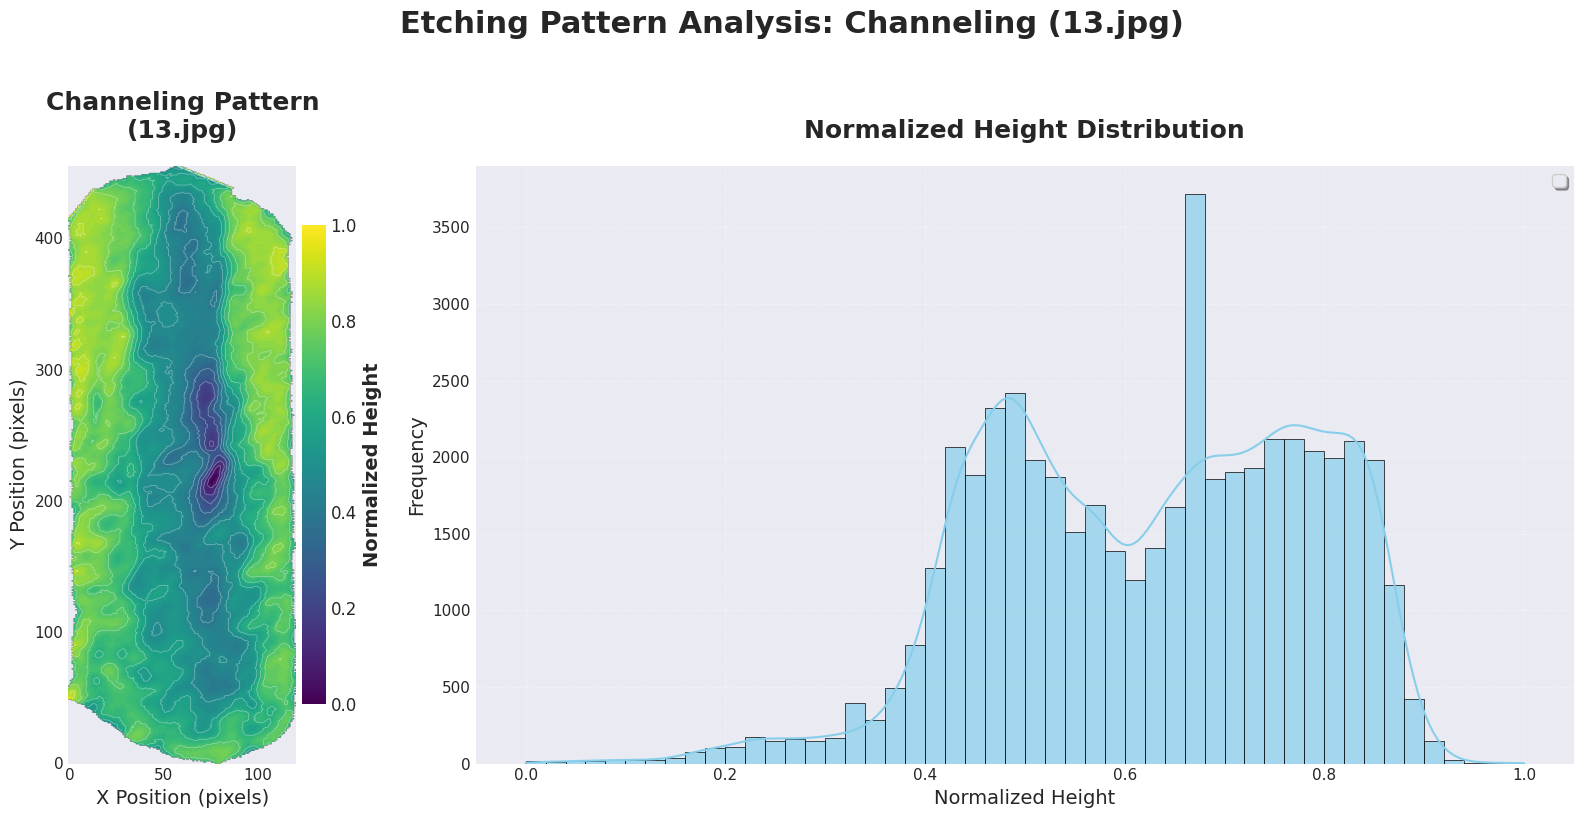

Height Distribution Statistics:
Mean: 0.6245
Median: 0.6415
Standard Deviation: 0.1588
Min: 0.0000
Max: 1.0000
Skewness: -0.3264
Kurtosis: -0.5209


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a modern, professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12

# Load and extract data for 13.jpg
image_path = './data/augmented_dataset/Channeling/13.jpg'
matrix = extract_surface_data(image_path)

# Flatten the matrix and remove NaNs for distribution
heights = matrix.flatten()
heights = heights[~np.isnan(heights)]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 4]})

# Left subplot: Image visualization
im = ax1.imshow(matrix, cmap='viridis', origin='lower',aspect='auto', vmin=0, vmax=1)
ax1.set_title('Channeling Pattern\n(13.jpg)', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('X Position (pixels)', fontsize=14)
ax1.set_ylabel('Y Position (pixels)', fontsize=14)
ax1.grid(False)

valid_mask = ~np.isnan(matrix)
if np.any(valid_mask):
    # Create coordinate grids
    y, x = np.mgrid[0:matrix.shape[0], 0:matrix.shape[1]]
    # Plot contours only where data exists
    ax1.contour(x, y, np.where(valid_mask, matrix, np.nan), 
                levels=15, colors='white', alpha=0.4, linewidths=0.5)
    
# Add colorbar with custom positioning
cbar = fig.colorbar(im, ax=ax1, shrink=0.8, aspect=20, pad=0.02)
cbar.set_label('Normalized Height', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Right subplot: Height distribution
sns.histplot(heights, bins=50, kde=True, color='skyblue', edgecolor='black', linewidth=0.5, ax=ax2, alpha=0.7)
ax2.set_title('Normalized Height Distribution', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Normalized Height', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)


# Customize the histogram
ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')

# Overall title
fig.suptitle('Etching Pattern Analysis: Channeling (13.jpg)', fontsize=22, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# Print some additional statistics
print("Height Distribution Statistics:")
print(f"Mean: {mean_height:.4f}")
print(f"Median: {median_height:.4f}")
print(f"Standard Deviation: {np.std(heights):.4f}")
print(f"Min: {np.min(heights):.4f}")
print(f"Max: {np.max(heights):.4f}")
print(f"Skewness: {np.mean(((heights - mean_height) / np.std(heights))**3):.4f}")
print(f"Kurtosis: {np.mean(((heights - mean_height) / np.std(heights))**4) - 3:.4f}")

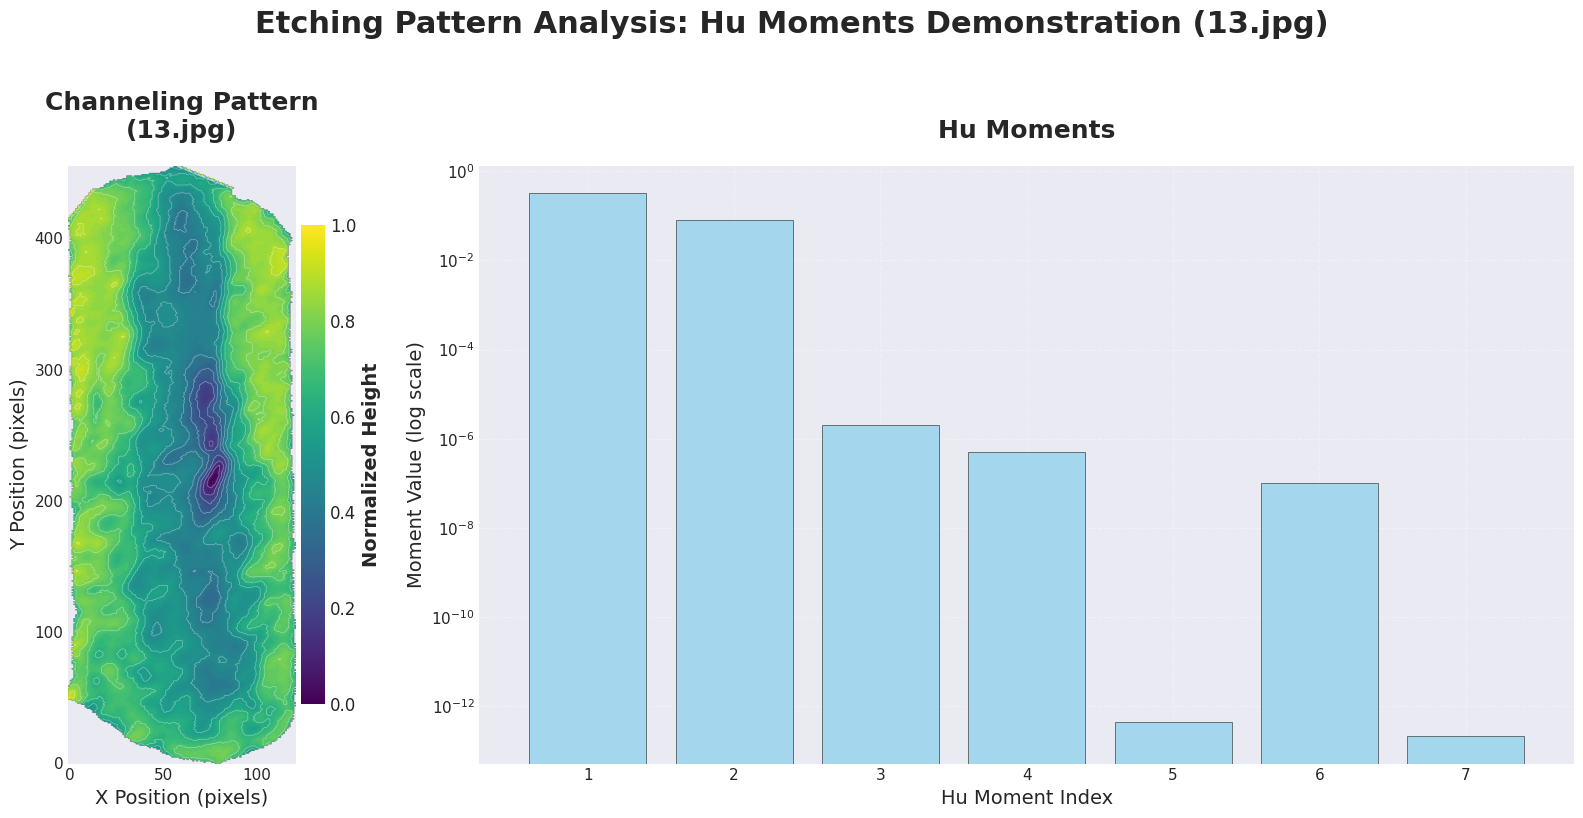

Hu Moments:
Hu1: 3.290103e-01
Hu2: 8.152363e-02
Hu3: 1.995119e-06
Hu4: 4.987186e-07
Hu5: 4.496619e-13
Hu6: 1.048154e-07
Hu7: 2.127945e-13


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

# Set a modern, professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12

# Load and extract data for 13.jpg
image_path = './data/augmented_dataset/Channeling/13.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert to HSV and create mask as in extract_surface_data
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_bound = np.array([0, 50, 50])
upper_bound = np.array([180, 255, 255])
mask = cv2.inRange(hsv, lower_bound, upper_bound)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("Could not find any data contours in the image.")

# Get the main contour
main_contour = max(contours, key=cv2.contourArea)

# Compute moments and Hu moments
moments = cv2.moments(main_contour)
hu_moments = cv2.HuMoments(moments).flatten()

# Extract the matrix for visualization
matrix = extract_surface_data(image_path)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 4]})

# Left subplot: Image visualization
im = ax1.imshow(matrix, cmap='viridis', origin='lower', aspect='auto', vmin=0, vmax=1)
ax1.set_title('Channeling Pattern\n(13.jpg)', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('X Position (pixels)', fontsize=14)
ax1.set_ylabel('Y Position (pixels)', fontsize=14)
ax1.grid(False)

valid_mask = ~np.isnan(matrix)
if np.any(valid_mask):
    # Create coordinate grids
    y, x = np.mgrid[0:matrix.shape[0], 0:matrix.shape[1]]
    # Plot contours only where data exists
    ax1.contour(x, y, np.where(valid_mask, matrix, np.nan), 
                levels=15, colors='white', alpha=0.4, linewidths=0.5)
    
# Add colorbar with custom positioning
cbar = fig.colorbar(im, ax=ax1, shrink=0.8, aspect=20, pad=0.02)
cbar.set_label('Normalized Height', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Right subplot: Hu Moments demonstration
ax2.bar(range(1, 8), hu_moments, color='skyblue', edgecolor='black', linewidth=0.5, alpha=0.7)
ax2.set_title('Hu Moments', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Hu Moment Index', fontsize=14)
ax2.set_ylabel('Moment Value (log scale)', fontsize=14)
ax2.set_yscale('log')  # Since Hu moments can vary greatly in scale
ax2.set_xticks(range(1, 8))
ax2.grid(True, alpha=0.3, linestyle='--')

# Overall title
fig.suptitle('Etching Pattern Analysis: Hu Moments Demonstration (13.jpg)', fontsize=22, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# Print Hu moments values
print("Hu Moments:")
for i, hu in enumerate(hu_moments, 1):
    print(f"Hu{i}: {hu:.6e}")

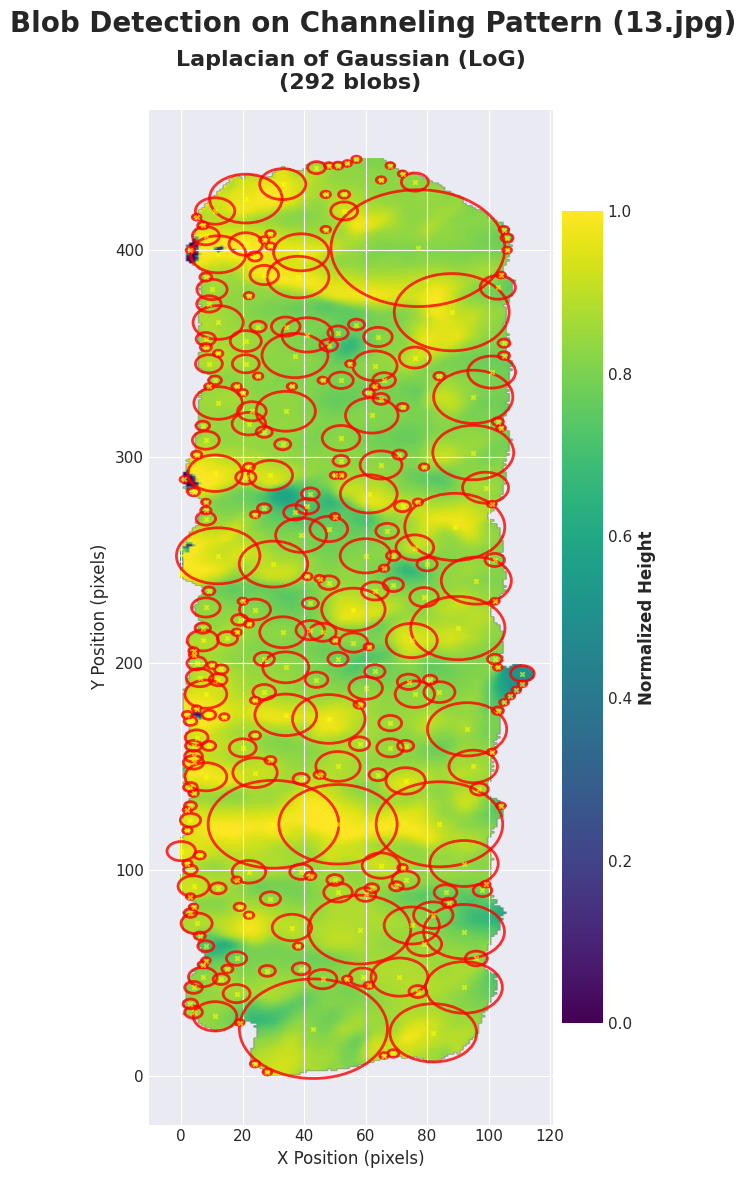

Blob Detection Statistics:
LoG: 292 blobs


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.feature import blob_log, blob_dog, blob_doh

# Set a modern, professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12

# Load and extract data for 13.jpg
image_path = './data/augmented_dataset/Pillar/85.jpg'
matrix = extract_surface_data(image_path)

# Convert matrix to uint8 for blob detection (handle NaN values)
matrix_normalized = np.nan_to_num(matrix, nan=0.0)
matrix_uint8 = (matrix_normalized * 255).astype(np.uint8)

# Detect blobs using Laplacian of Gaussian (LoG)
blobs_log = blob_log(matrix_uint8, max_sigma=20, num_sigma=200, threshold=.003)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)  # Compute radii

# Create figure with single subplot
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

# Display the surface matrix
im = ax.imshow(matrix, cmap='viridis', origin='lower', aspect='auto', vmin=0, vmax=1)
ax.set_title(f'Laplacian of Gaussian (LoG)\n({len(blobs_log)} blobs)', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('X Position (pixels)', fontsize=12)
ax.set_ylabel('Y Position (pixels)', fontsize=12)

# Plot detected blobs as circles
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False, alpha=0.8)
    ax.add_patch(c)

# Add a small marker at the center of each blob
if len(blobs_log) > 0:
    ax.scatter(blobs_log[:, 1], blobs_log[:, 0], s=10, c='yellow', marker='x', alpha=0.6)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.8, aspect=20, pad=0.02)
cbar.set_label('Normalized Height', fontsize=12, fontweight='bold')

# Overall title
fig.suptitle('Blob Detection on Channeling Pattern (13.jpg)', fontsize=20, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
plt.show()

# Print blob statistics
print("Blob Detection Statistics:")
print(f"LoG: {len(blobs_log)} blobs")


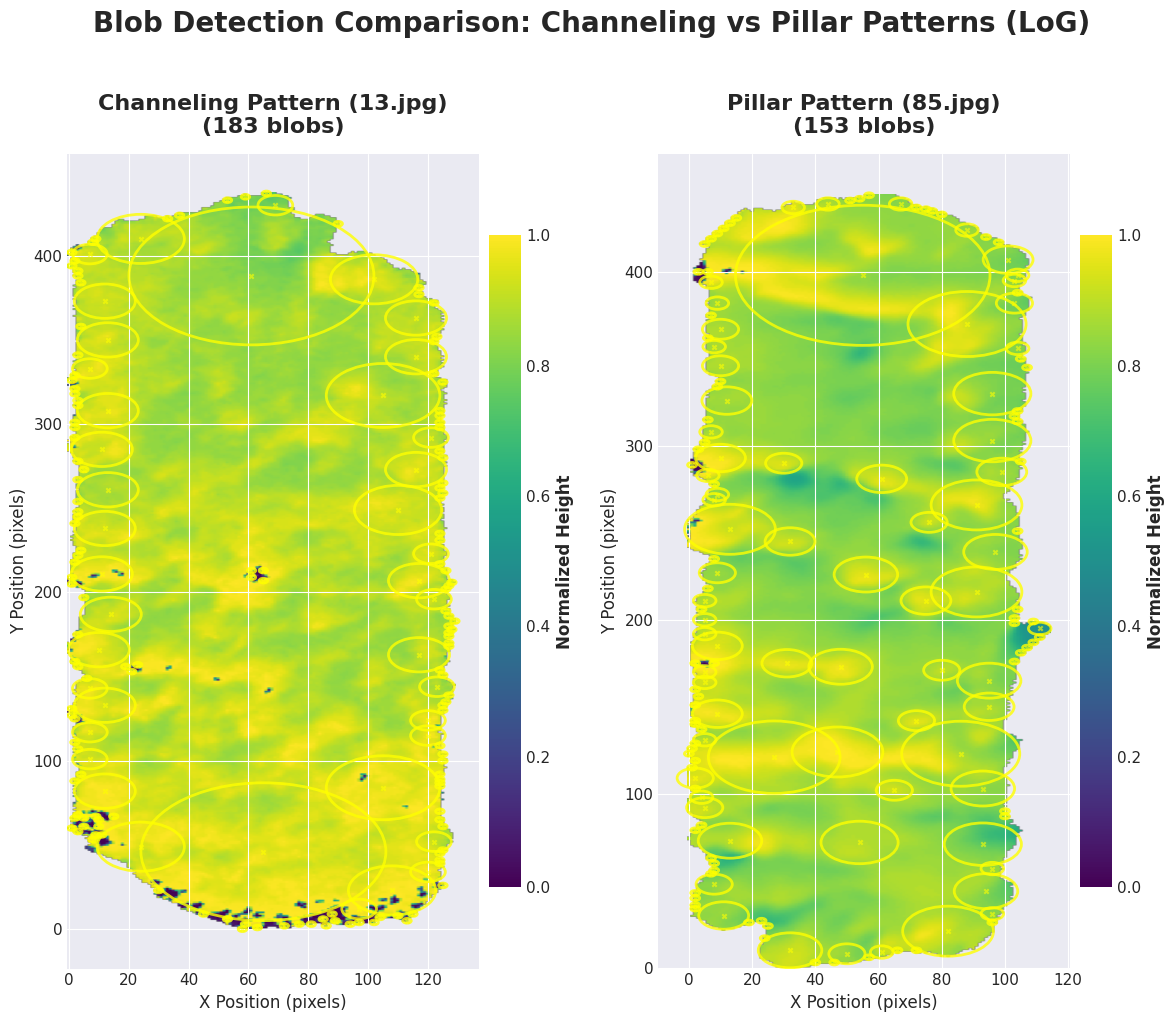

Blob Detection Statistics:
Channeling (13.jpg): 183 blobs


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.feature import blob_log

# Set a modern, professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12

# Load and extract data for both images
image_path_channeling = './data/augmented_dataset/Roughness/50.jpg'
image_path_pillar = './data/augmented_dataset/Pillar/85.jpg'

matrix_channeling = extract_surface_data(image_path_channeling)
matrix_pillar = extract_surface_data(image_path_pillar)

# Convert matrices to uint8 for blob detection (handle NaN values)
matrix_channeling_normalized = np.nan_to_num(matrix_channeling, nan=0.0)
matrix_channeling_uint8 = (matrix_channeling_normalized * 255).astype(np.uint8)

matrix_pillar_normalized = np.nan_to_num(matrix_pillar, nan=0.0)
matrix_pillar_uint8 = (matrix_pillar_normalized * 255).astype(np.uint8)

# Detect blobs using Laplacian of Gaussian (LoG) for both
blobs_channeling = blob_log(matrix_channeling_uint8, max_sigma=60, num_sigma=20, threshold=0.1)
blobs_channeling[:, 2] = blobs_channeling[:, 2] * np.sqrt(2)  # Compute radii

blobs_pillar = blob_log(matrix_pillar_uint8, max_sigma=30, num_sigma=20, threshold=0.03)
blobs_pillar[:, 2] = blobs_pillar[:, 2] * np.sqrt(2)  # Compute radii

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

# Left subplot: Channeling Pattern
im1 = ax1.imshow(matrix_channeling, cmap='viridis', origin='lower', aspect='auto', vmin=0, vmax=1)
ax1.set_title(f'Channeling Pattern (13.jpg)\n({len(blobs_channeling)} blobs)', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('X Position (pixels)', fontsize=12)
ax1.set_ylabel('Y Position (pixels)', fontsize=12)

# Plot detected blobs for channeling
for blob in blobs_channeling:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False, alpha=0.8)
    ax1.add_patch(c)
if len(blobs_channeling) > 0:
    ax1.scatter(blobs_channeling[:, 1], blobs_channeling[:, 0], s=10, c='yellow', marker='x', alpha=0.6)

# Add colorbar for channeling
cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8, aspect=20, pad=0.02)
cbar1.set_label('Normalized Height', fontsize=12, fontweight='bold')

# Right subplot: Pillar Pattern
im2 = ax2.imshow(matrix_pillar, cmap='viridis', origin='lower', aspect='auto', vmin=0, vmax=1)
ax2.set_title(f'Pillar Pattern (85.jpg)\n({len(blobs_pillar)} blobs)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('X Position (pixels)', fontsize=12)
ax2.set_ylabel('Y Position (pixels)', fontsize=12)

# Plot detected blobs for pillar
for blob in blobs_pillar:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False, alpha=0.8)
    ax2.add_patch(c)
if len(blobs_pillar) > 0:
    ax2.scatter(blobs_pillar[:, 1], blobs_pillar[:, 0], s=10, c='yellow', marker='x', alpha=0.6)

# Add colorbar for pillar
cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8, aspect=20, pad=0.02)
cbar2.set_label('Normalized Height', fontsize=12, fontweight='bold')

# Overall title
fig.suptitle('Blob Detection Comparison: Channeling vs Pillar Patterns (LoG)', fontsize=20, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# Print blob statistics
print("Blob Detection Statistics:")
print(f"Channeling (13.jpg): {len(blobs_channeling)} blobs")
